In [2]:
import sys
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import shap

sys.path.append(os.path.abspath('..'))

from src.preprocess import Preprocessor
prep = Preprocessor()

data = pd.read_csv('../data/retail_store_inventory.csv')
clean_data = prep.common_preprocess_data(data.drop(columns=['Demand Forecast']))

# Time series split

We need to split the data first in order to avoid data leakage

In [3]:
# First we split the data into train and test sets using a time series split by group (Store ID and Product ID).
def temp_split_by_group (df, group_col=['Store ID','Product ID'], test_size=0.2):
    train, test = [], []
    for _, group in df.groupby(group_col):
        group = group.sort_values('Date') # Ensure the group is sorted by date
        n = len(group)
        if n <= 2: # Ensure there are enough samples to split
            continue
        train_size = int(n * (1 - test_size))
        train.append(group.iloc[:train_size])
        test.append(group.iloc[train_size:])
    return pd.concat(train), pd.concat(test)

In [4]:
# Split the clean data into train and test sets
train, test = temp_split_by_group(clean_data)
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (51200, 54), Test shape: (12900, 54)


In [6]:
# We will now define the target variable and the features to be used for modeling.
target = 'Units Sold' # We define the target variable
exclude_cols = ['Date', target] # We define the columns to exclude from the features, which are the date and target variable columns

features = [col for col in train.columns if col not in exclude_cols] # We create a list of features excluding the target and date columns
X_train, X_test = train[features], test[features] # We create the train and test sets for the features
y_train, y_test = train[target], test[target] # We create the train and test sets for the target variable

# Baseline XGBoost model

In [7]:
model = xgb.XGBRegressor() # Initialize the XGBoost model, with default parameters
model.fit(X_train, y_train) # Fit the model to the training data
y_pred = model.predict(X_test) # Predict the target variable for the test set

mse = mean_squared_error(y_test, y_pred) # Calculate the mean squared error of the predictions
print(f"Mean Squared Error: {mse}") # Print the mean squared error
print(f"Mean values: {y_test.mean()}, {y_pred.mean()}") # Print the mean values of the target variable and the predictions

Mean Squared Error: 51.689449310302734
Mean values: 136.24868217054262, 136.22572326660156


In [8]:
# Now we want to see the MSE by group, to see if there are some groups that are harder to predict than others
test['Units Sold pred'] = y_pred # Add the predictions to the test set
mse_by_group = test.groupby(['Store ID', 'Product ID']).apply(
    lambda x: mean_squared_error(x[target], x['Units Sold pred'])
).reset_index(name='MSE')

# Sort the MSE by group and get the top 10 groups with the highest MSE
top_mse = mse_by_group.sort_values('MSE', ascending=False).head(10)
print(top_mse)

    Store ID  Product ID        MSE
82         4           2  91.390396
8          0           8  88.273788
16         0          16  82.768562
3          0           3  72.675148
26         1           6  72.381462
74         3          14  72.209900
54         2          14  70.725067
84         4           4  69.972855
30         1          10  69.874290
28         1           8  69.802216


C:\Users\DAMER03\AppData\Local\Temp\ipykernel_24768\3582661150.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_group = test.groupby(['Store ID', 'Product ID']).apply(


Text(0.5, 1.0, 'Residuals for Store ID 3, Product ID 6')

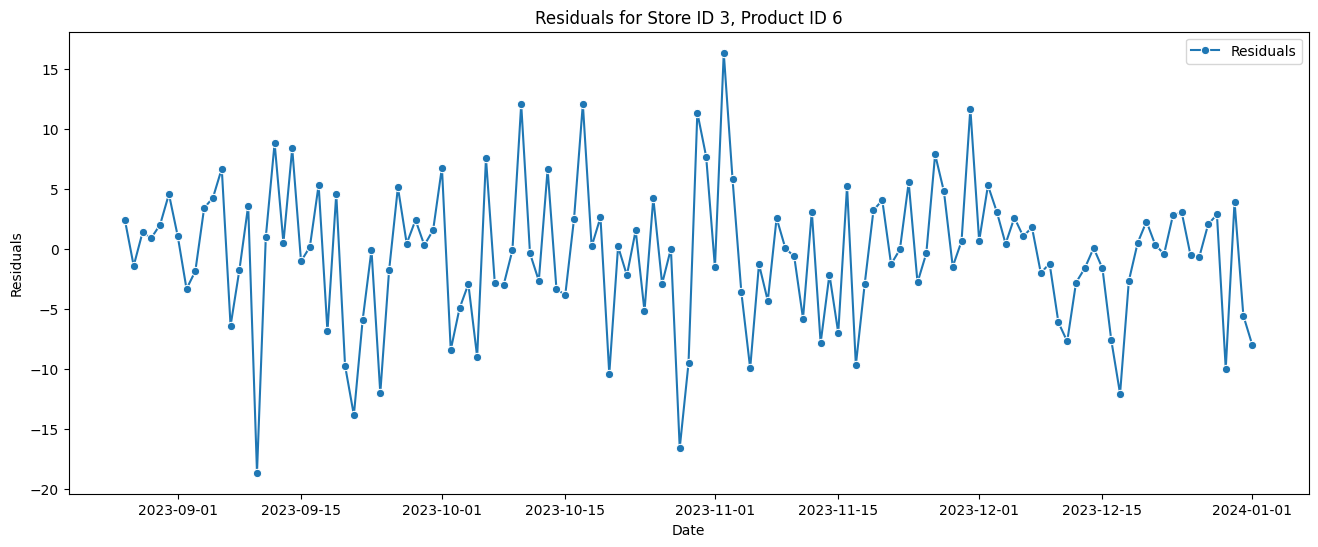

In [9]:
# we can analyze the residuals to see if there are any patterns on the groups with the highest MSE
test['Residuals'] = test[target] - test['Units Sold pred'] # Calculate the residuals

group = test[(test['Store ID'] == 3) & (test['Product ID'] == 6)] # Select a group with high MSE
plt.figure(figsize=(16, 6))
sns.lineplot(data=group, x='Date', y='Residuals', marker='o', label='Residuals')
plt.title(f"Residuals for Store ID {group['Store ID'].iloc[0]}, Product ID {group['Product ID'].iloc[0]}")

There is no visible pattern in the residuals analysis

Text(0.5, 1.0, 'Actual vs Predicted Units Sold for Store ID 4, Product ID 2')

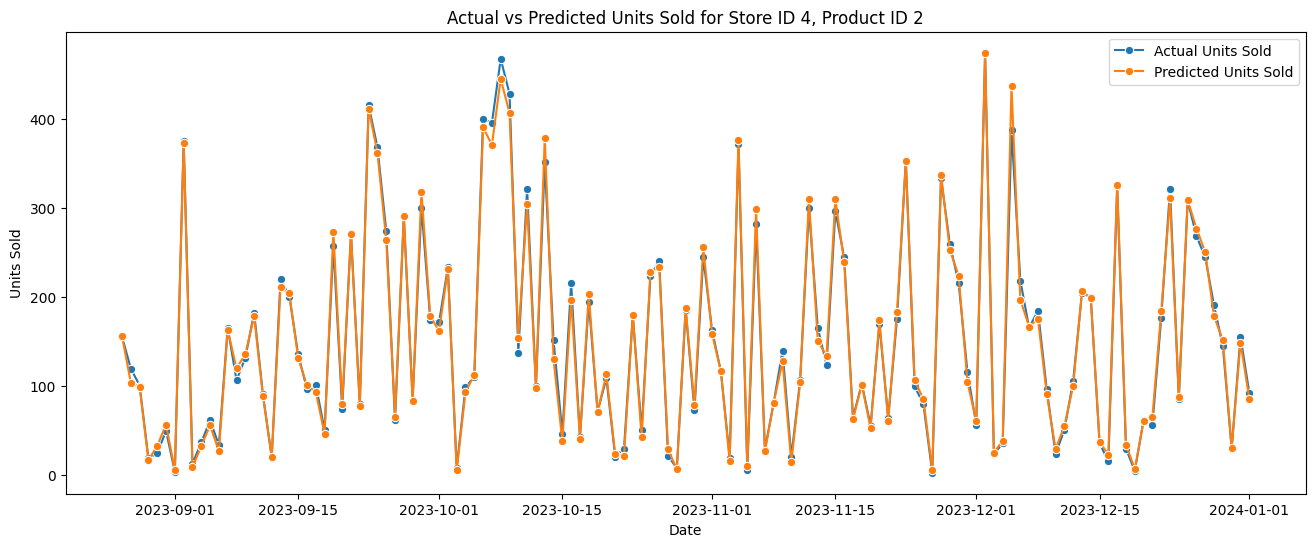

In [11]:
group = test[(test['Store ID'] == 4) & (test['Product ID'] == 2)] # Select a group with high MSE
plt.figure(figsize=(16, 6))
sns.lineplot(data=group, x='Date', y='Units Sold', label='Actual Units Sold', marker='o')
sns.lineplot(data=group, x='Date', y='Units Sold pred', label='Predicted Units Sold', marker='o')
plt.title(f"Actual vs Predicted Units Sold for Store ID {group['Store ID'].iloc[0]}, Product ID {group['Product ID'].iloc[0]}")

# SHAP (Shapley Additive Explanations)

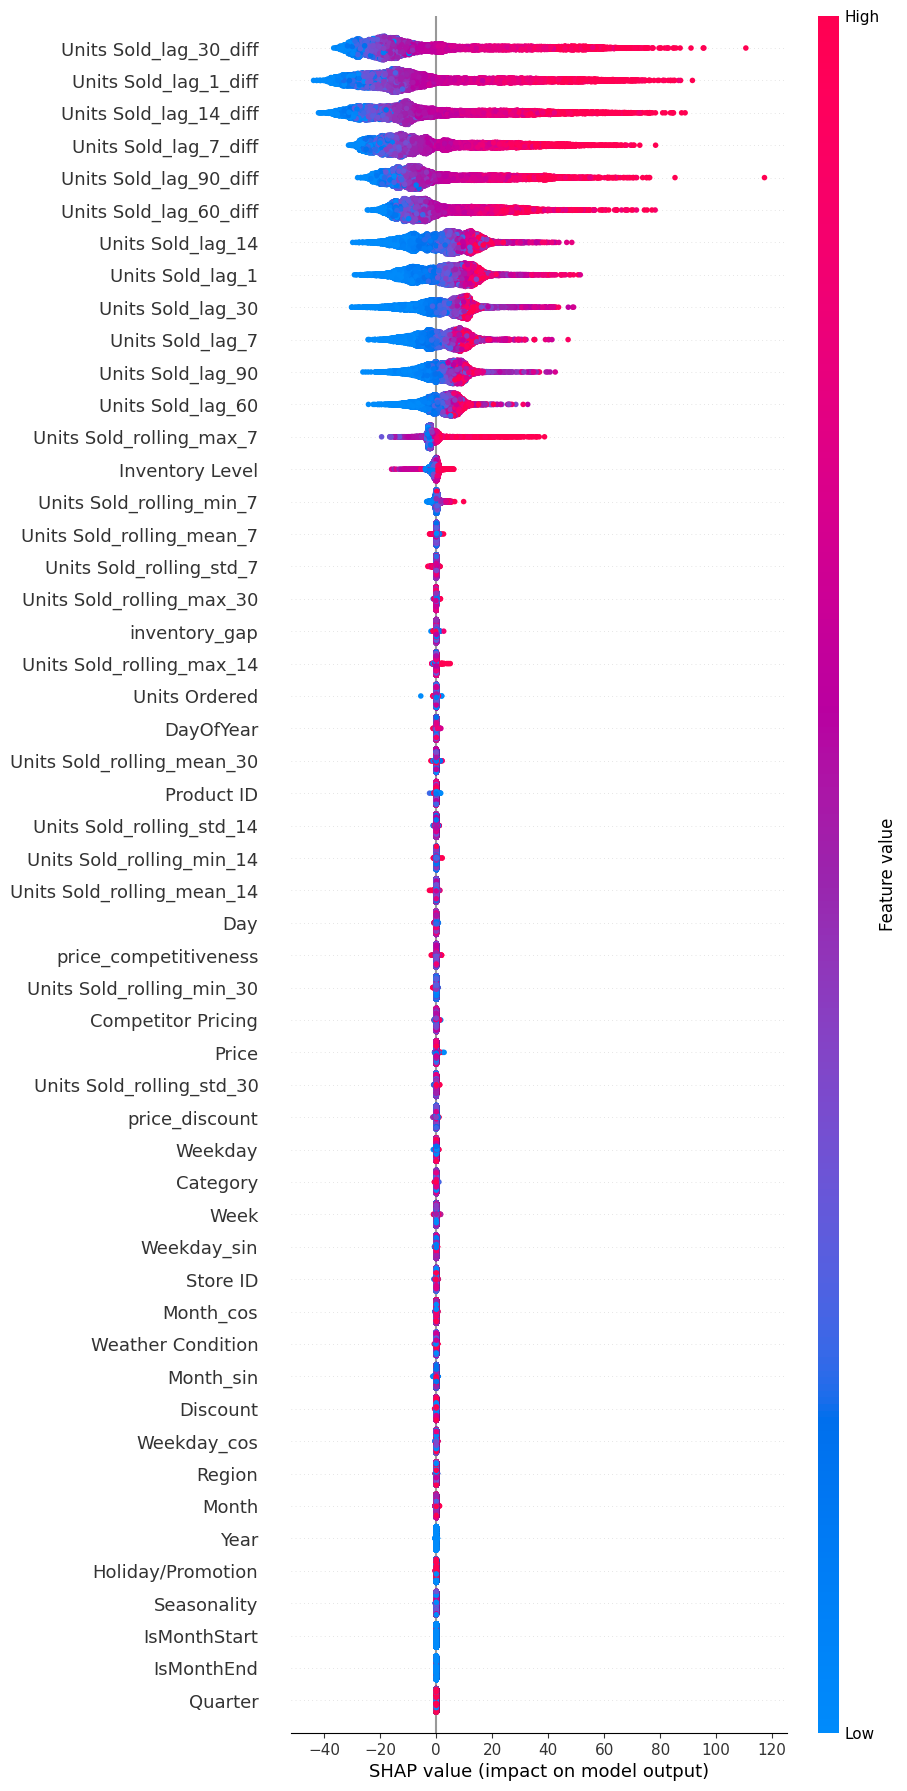

In [12]:
explainer = shap.Explainer(model) # Initialize the SHAP explainer
shap_values = explainer(X_test) # Calculate the SHAP values for the test set
shap.plots.beeswarm(shap_values, max_display=X_test.shape[1])

We can analyze the SHAP values as follows:

Some variables don’t contribute much to the prediction and may introduce noise, such as "Quarter" and "Is Month Start".

Others, like inventory levels, play a significant role in the model’s performance.

Now, why is inventory level so strongly correlated with units sold? There could be several reasons. First, it's important to clarify that correlation does not imply causation having more inventory doesn't directly cause higher sales.

However, some possible explanations include:

* Sales might be limited by inventory. Poor inventory management could mean businesses are only selling what they have on hand, not what they could potentially sell.

* Higher sales periods might prompt businesses to increase their stock in preparation.

* Stores with consistently high sales may follow stock policies that require them to hold more inventory, meaning higher sales are associated with higher inventory levels.

# Most important features

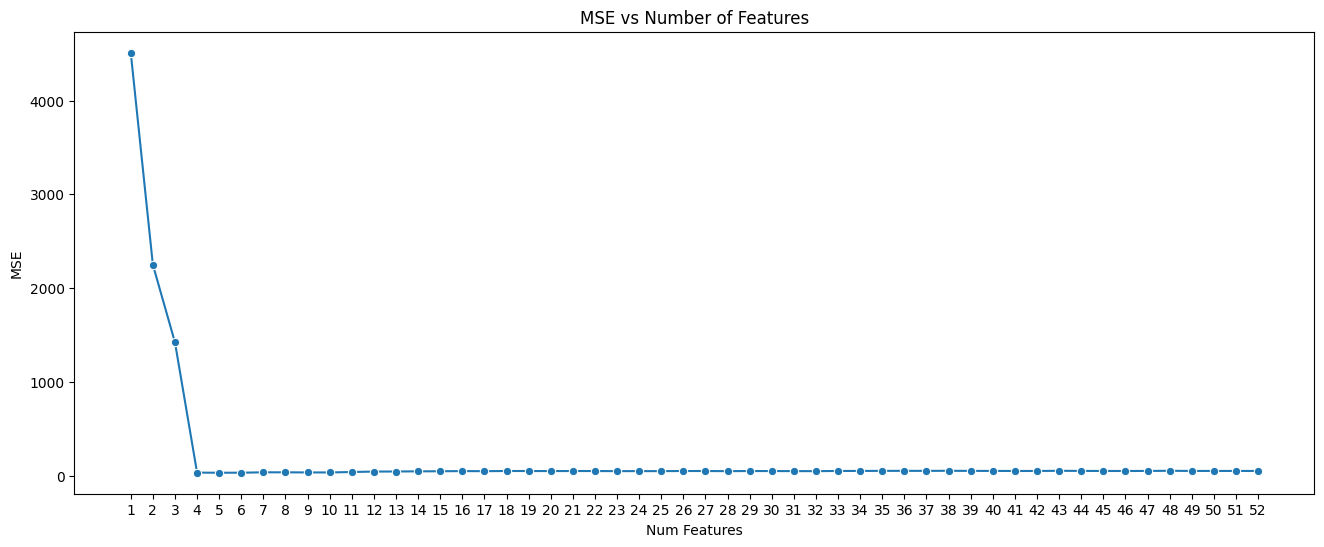

In [13]:
abs_shap_values = np.abs(shap_values.values.mean(axis=0)) # Calculate the absolute mean SHAP values for each feature

# Create a DataFrame with the feature importances
importance = pd.DataFrame({
    'Feature': X_test.columns, 
    'Importance': abs_shap_values
}).sort_values(by='Importance', ascending=False) # Create a DataFrame with the feature importances

# We want to create a loop to test the number of features and see how the MSE changes
results = [] # Initialize a list to store the results
for i in range(1, len(importance) + 1):
    selected_features = importance['Feature'][:i].tolist() # Select the top i features

    X_train_subset = X_train[selected_features] # Create a subset of the training data with the selected features
    X_test_subset = X_test[selected_features] # Create a subset of the test data with the selected features
    
    model.fit(X_train_subset, y_train) # Fit the model to the training data
    y_pred_subset = model.predict(X_test_subset) # Predict the target variable for the test set
    
    mse_subset = mean_squared_error(y_test, y_pred_subset) # Calculate the mean squared error of the predictions
    results.append((i, mse_subset)) # Append the results to the list

# Create a DataFrame with the results
results_df = pd.DataFrame(results, columns=['Num Features', 'MSE'])

plt.figure(figsize=(16, 6))
sns.lineplot(data=results_df, x='Num Features', y='MSE',marker='o' ) # Plot the results
plt.title('MSE vs Number of Features') # Set the title of the plot
plt.xticks(ticks=range(1, len(results_df) + 1))
plt.show()

We can observe that when we have the top 4 reaches near its minimum, other features just add noise

In [20]:
results_df.sort_values('MSE', inplace=True) # Sort the results by the MSE
print(results_df.head())
print(importance.head())

   Num Features        MSE
4             5  32.608448
5             6  32.770187
3             4  33.714741
9            10  35.461220
8             9  35.611469
                   Feature  Importance
31   Units Sold_lag_1_diff    3.932390
34  Units Sold_lag_30_diff    3.896050
33  Units Sold_lag_14_diff    3.486410
28       Units Sold_lag_30    2.925524
27       Units Sold_lag_14    2.520400


We can see that with the first 5 features the MSE will be the lowest, so this are the features we will use

In [26]:
model = xgb.XGBRegressor() # Initialize the XGBoost model, with default parameters
model.fit(X_train[['Units Sold_lag_1_diff','Units Sold_lag_30_diff','Units Sold_lag_14_diff', 'Units Sold_lag_30','Units Sold_lag_14']], y_train) # Fit the model to the training data using only the selected features
y_pred = model.predict(X_test[['Units Sold_lag_1_diff','Units Sold_lag_30_diff','Units Sold_lag_14_diff', 'Units Sold_lag_30','Units Sold_lag_14']]) # Predict the target variable for the test set

mse = mean_squared_error(y_test, y_pred) # Calculate the mean squared error of the predictions
print(f"Mean Squared Error: {mse}") # Print the mean squared error
print(f"Mean values: {y_test.mean()}, {y_pred.mean()}") # Print the mean values of the target variable and the predictions

Mean Squared Error: 32.60844802856445
Mean values: 136.24868217054262, 136.1624298095703


As we saw previously using this 5 features we can reduce the MSE from 51.69 to 32.61 a 37% reduction just selecting the best variables